Let's take all the results from the Severn Bridge Half and do some analysis! This is an example of basic scraping and data analysis.

In [105]:
# for parsing HTML page
import requests
from bs4 import BeautifulSoup
from datetime import time, timedelta, datetime
# for easy import/export
import json
# for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn

In [148]:
pd.__version__, requests.__version__, np.__version__, mpl.__version__, seaborn.__version__

('0.16.2', '2.7.0', '1.9.2', '1.4.3', '0.6.0')

In [106]:
seaborn.set_style("whitegrid")

%matplotlib inline
# get_ipython().magic(u'pylab inline')
mpl.rcParams['figure.figsize'] = (14.0, 6.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
# mpl.rcParams['xtick.major.size'] = 10
# mpl.rcParams['ytick.major.size'] = 10
# mpl.rcParams['xtick.minor.size'] = 5
# mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.scatterpoints'] = 1

# Scraping the data 

First, we need to scrape the table of results from the website. Let's use `requests` to pull the html, and `BeautifulSoup4` to traverse the HTML elements.

In [70]:
# Get the page HTML, and the table element
page = requests.get(r"https://www.fullonsport.com/event/5834/results")
# soup = BeautifulSoup(page.text, 'html.parser')  # included parser
soup = BeautifulSoup(page.text, 'lxml')  # lxml parser
# Get the table of results
raw_table = soup.find(id='my-results')

In [187]:
# Get the table column names
columns = [str(x.string) for x in raw_table.find('thead').findAll('th')]
print 'Columns:', columns

Columns: ['Position', 'Race No', 'Firstname', 'Lastname', 'Club', 'Club Pos', 'Category', 'Cat Pos', 'Time', 'Chip Time', 'Status']


In [208]:
# Make a class to hold the runner info

class Runner(object):
    """Class to describe entry."""
    def __init__(self, gun_position, race_num, firstname, surname, club, club_pos, 
                 category, category_pos, gun_time, chip_time, status):
        self.gun_position = int(gun_position) # based off gun time
        self.race_num = int(race_num)
#         self.firstname = firstname
#         self.surname = surname
        self.name = "%s %s" % (firstname, surname)
#         self.club = club
#         self.club_pos = int(club_pos)
        self.category = category
        fmt = '%H:%M:%S'
        # Gun time is the time differencce between the gun firing and the runner's finish
        # incase there is a missing entry
        self.gun_datetime = gun_time
#         self.gun_datetime = datetime.strptime(gun_time, fmt) if gun_time else datetime.max  
#         self.gun_time = self.gun_datetime.time()
        # Chip time is the time difference between when runner crossing the start and finish lines
        self.chip_datetime = chip_time
#         self.chip_datetime = datetime.strptime(chip_time, fmt) if chip_time else datetime.max
#         self.chip_time = self.chip_datetime.time()
#         self.gun_chip_delta = self.gun_datetime - self.chip_datetime # difference between gun time and chip time
        self.status = status
    
    def json(self):
        """Method to convert to JSON output"""
        pass

In [209]:
# Let's get all the rows!
runner_table = []
for child in raw_table.children:
    if child.name != 'tr':
        continue
    row = {k:str(v.text) for k, v in zip(columns, child.children)}
#     print row
    runner = Runner(gun_position=row['Position'], race_num=row['Race No'], 
                    firstname=row['Firstname'], surname=row['Lastname'], 
                    club=row['Club'], club_pos=row['Club Pos'], 
                    category=row['Category'], category_pos=row['Cat Pos'], 
                    gun_time=row['Time'], chip_time=row['Chip Time'], 
                    status=row['Status'])
    runner_table.append(runner)
    

In [210]:
print runner_table[0].name
runner_table[0].__dict__

Steve Way


{'category': 'M40+',
 'chip_datetime': '01:12:39',
 'gun_datetime': '01:12:39',
 'gun_position': 1,
 'name': 'Steve Way',
 'race_num': 2513,
 'status': 'RES'}

# Analysis - making the DataFrame

So now we have all the data in the table in our objects, stored in the list `runner_table`. This isn't very convenient for analysis though - let's uses a `pandas` DataFrame instead!

In [238]:
df = pd.DataFrame(data=[x.__dict__ for x in runner_table], 
                  columns=runner_table[0].__dict__.keys())
df = df[df.chip_datetime != '']
print df.columns
df.head()

Index([u'category', u'status', u'name', u'gun_position', u'gun_datetime',
       u'chip_datetime', u'race_num'],
      dtype='object')


,category,status,name,gun_position,gun_datetime,chip_datetime,race_num
0,M40+,RES,Steve Way,1,01:12:39,01:12:39,2513
1,M40+,RES,Paul Griffiths,2,01:13:23,01:13:23,941
2,Male Senior,RES,Stephen Paterson,3,01:13:59,01:13:59,1836
3,Male Senior,RES,stuart hawkes,4,01:14:43,01:14:42,1025
4,M45+,RES,Tony Wright,5,01:17:09,01:17:08,2795


In [231]:
num_runners = len(df.index)
print num_runners, 'runners'

2304 runners


We need to convert all the time elements to the correct type of object.

In [239]:
time_converter = np.vectorize(lambda x : pd.to_datetime(x, format='%H:%M:%S'))
df.chip_datetime = df.chip_datetime.apply(time_converter)
df.gun_datetime = df.gun_datetime.apply(time_converter)

One thing we need to recalculate is position. The default 'position' we scraped is based off the _gun_ time, not the _chip_ time (which is much fairer).

In [241]:
df = df.sort_index(by=['chip_datetime']).reset_index(drop=True)
df['chip_position'] = df.index + 1

Now we can actually do some analysis!

# Analysis - plots'n'stuff 

We can now start splitting, sorting, clustering, etc to find any potential patterns.

In [242]:
# Split DataFrame into separate male and female DataFrames
df_male = df[df.category.str.contains('M')]
df_female = df[df.category.str.contains('F')]

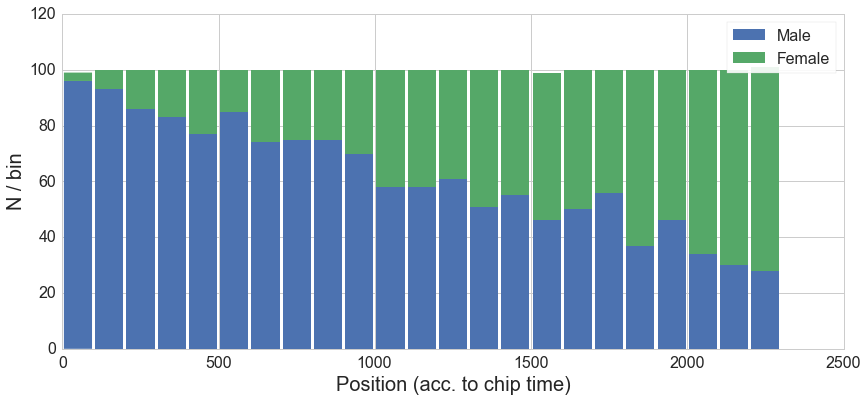

In [244]:
pos = 'chip_position'
nbins = 23
lw = 0
x_range = [0, 2300]
normed = False
plt.hist([df_male[pos].values, df_female[pos].values], 
         bins=nbins, stacked=True, histtype='barstacked',
         label=['Male', 'Female'], lw=lw, range=x_range, 
         rwidth=0.9)
plt.xlabel('Position (acc. to chip time)')
plt.ylabel("N / bin")
# plt.xlim(right=2300 * 1.1)
plt.legend(loc=0)
plt.minorticks_on()